# Dinner Table scenario #

In this notebook we discuss framing the task of setting a dinner table as an instance of PUnS

In [9]:
from SpecificationMDP import *
from LearningAgents import *
import pandas as pd
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from mod_relational import *
matplotlib.rcParams['figure.figsize'] = [20,15]
%matplotlib inline

def RecordLearningCurve(MDP, Learner, max_episodes = 10000, steps = 10, temp = 0.01, verbose = False):
    episodes = 0
    mean_rewards = []
    rewards = []
    std_rewards = []
    mean_episode_length = []
    ep = []
    
    for i in range(0,max_episodes,steps):
        
        if verbose:
            print(f'\r Training and evaluating with {i} episodes        ', end = '')
        
        episodes = episodes + steps
        ep.append(episodes)
        Learner.explore(episode_limit = steps, verbose = False)
        evaluator = ExplorerAgent(MDP, input_policy = Learner.create_learned_softmax_policy(temp))
        evaluator.explore(episode_limit = 50)
        r = [record[-1][3] for record in evaluator.episodic_record]
        l = [len(record) for record in evaluator.episodic_record]
        
        rewards.append(r)
        mean_rewards.append(np.mean(r))
        std_rewards.append(np.std(r))
        mean_episode_length.append(np.mean(l))
        
        #print(mean_rewards[-1])
        
        
    return rewards, mean_rewards, std_rewards, mean_episode_length, ep

def TrainAndTest(LearnerType, MDP, directory, nRuns = 10, episodes = 1000, steps = 1, temp=0.01, verbose=True):
    
    if not os.path.exists(directory):
        os.mkdir(directory)
    for i in range(nRuns):
        print(f'Run: {i} of {nRuns}')
        agent = LearnerType(MDP)
        LCRecord = RecordLearningCurve(MDP, agent, max_episodes=episodes, steps = steps, temp = temp, verbose=verbose)
        with open(os.path.join(directory, f'LC{i}'),'wb') as file:
            pickle.dump({'LC':LCRecord},file)
        del agent

        
def ReadLCData(directory, label):
    RawData = {}
    for r,d,files in os.walk(directory):
        for (i,f) in enumerate(files):
            Data = pickle.load(open(os.path.join(r,f),'rb'))
            reward, mean_reward, reward_std, _, episodes = Data['LC']
            
            for replicates, ep in zip(reward, episodes):
                for x in replicates:
                    RawData[len(RawData)] = [x,ep,label,i]
    return pd.DataFrame.from_dict(RawData, orient = 'index', columns = ['Mean Terminal Reward', 'Episode', 'Learning agent','run'])



We begin by creating an instance of the dinner table MDP with the minimum regret formulation chosen as the reward.

In [2]:
MDP = CreateDinnerMDP(reward_type='min_regret')
print('The number of formulas in the FSM: ', len(MDP.specification_fsm._formulas))
print('The number of unique states in the specification FSM: ', len(MDP.specification_fsm.states2id))
#EnvMDP = MDP.control_mdp

@[DinnerPlate=0, SmallPlate=0, Bowl=0, Knife=0, Fork=0, Spoon=0, Mug=0, Glass=0, ]
The number of formulas in the FSM:  25
The number of unique states in the specification FSM:  3024


We can inspect what the probabilities of the specifications were in descending order

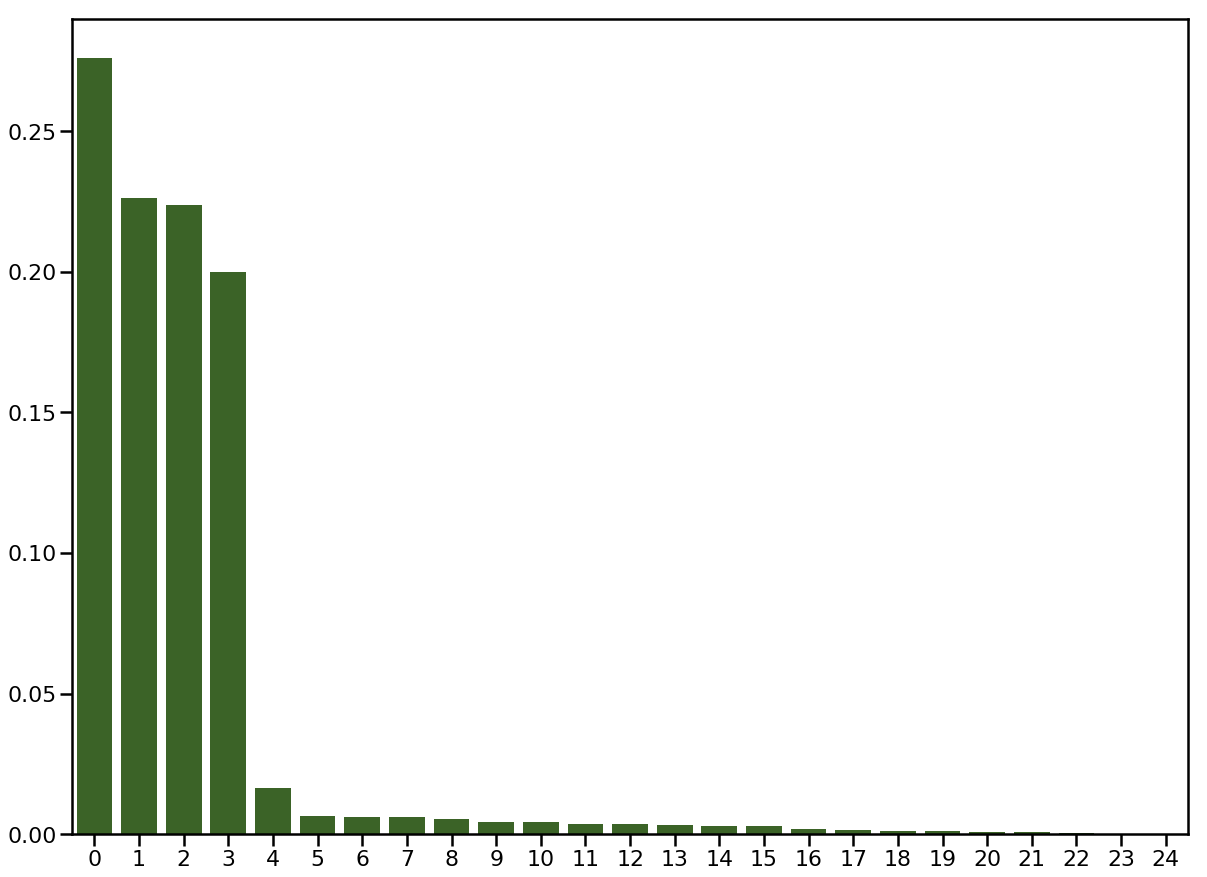

In [3]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x=list(range(len(MDP.specification_fsm._formulas))), y = MDP.specification_fsm._partial_rewards, color = '#386d1d')

Suppose we had compiled the specification MDP with just the most likely specification

In [4]:
MDP_map = CreateDinnerMDP(reward_type = 'map')
print('The number of formulas in the FSM: ', len(MDP_map.specification_fsm._formulas))
print('The number of unique states in the specification FSM: ', len(MDP_map.specification_fsm.states2id))

@[DinnerPlate=0, SmallPlate=0, Bowl=0, Knife=0, Fork=0, Spoon=0, Mug=0, Glass=0, ]
The number of formulas in the FSM:  1
The number of unique states in the specification FSM:  193


We can also compile with the chance constrained formulation with $\delta = 0.95$.

In [6]:
MDP_cc = CreateDinnerMDP(reward_type = 'chance_constrained', risk_level = 0.05)
print('The number of formulas in the FSM: ', len(MDP_cc.specification_fsm._formulas))
print('The number of unique states in the specification FSM: ', len(MDP_cc.specification_fsm.states2id))

@[DinnerPlate=0, SmallPlate=0, Bowl=0, Knife=0, Fork=0, Spoon=0, Mug=0, Glass=0, ]
The number of formulas in the FSM:  7
The number of unique states in the specification FSM:  705


And now with $\delta = 0.90$.

In [8]:
MDP_cc = CreateDinnerMDP(reward_type = 'chance_constrained', risk_level = 0.1)
print('The number of formulas in the FSM: ', len(MDP_cc.specification_fsm._formulas))
print('The number of unique states in the specification FSM: ', len(MDP_cc.specification_fsm.states2id))

@[DinnerPlate=0, SmallPlate=0, Bowl=0, Knife=0, Fork=0, Spoon=0, Mug=0, Glass=0, ]
The number of formulas in the FSM:  4
The number of unique states in the specification FSM:  449


Notice that with the *most likely* and the *chance constrained* formulation, the number of formulas in the posterior and the number of unique specification states is a lot smaller. 

## Training Q-learning agents ##

For each learning agent, we train the agent one episode at a time. Then at each step in learning, we evaluate its performance on an agent executing the learned softmax policy (temperature parameter 0.01) for 50 test runs. The terminal reward value for each of these 50 runs is recorded. This procedure is repeated for all training runs executed. For each training run, the record of the learning curve is saved in a directory specified by the user. The data points include the statistics of the reward across the run, the number of training episodes completed before the testing run was performed and type of learning agent.

We start by training a Q-learning agent without any counterfactual Q-value updates and recording its learning curve over a period of 1000 episodes. The learning curve statistics will be stored in the folder `./Q_Agent/` that we can access later. Note that this run is for the MDP compiled with the minimum regret criterion.

In [ ]:
TrainAndTest(CFAgent, MDP, 'Q_Agent', nRuns = 10, episodes = 1000)

We have provided data for 10 training runs of the learning agent without doing any counterfactual updates in the accompanying directory. So you don't need to run the training and evaluations. 

Similarly we record the learning curve for the agent when performing counterfactual updates and store in it the folder `./CFAgent`. Again we have provided data for 10 training runs, so you do not need to run this. In our implementation all the counterfactual Q-function updates are done serially, however in the tabular representation they would be updating different location of the memory, thus these updates can be performed in parallel in an optimized implementation.

In [ ]:
CFAgent = lambda MDP: QLearningAgent(MDP, counterfactual_updates=True)
TrainAndTest(CFAgent, MDP, 'CFAgent', episodes = 500)

## Visualizing learning curves ##

### No counterfactual updates ###

First lets plot the learning curve for median terminal reward for only the Q-learning agent separated by the training runs.

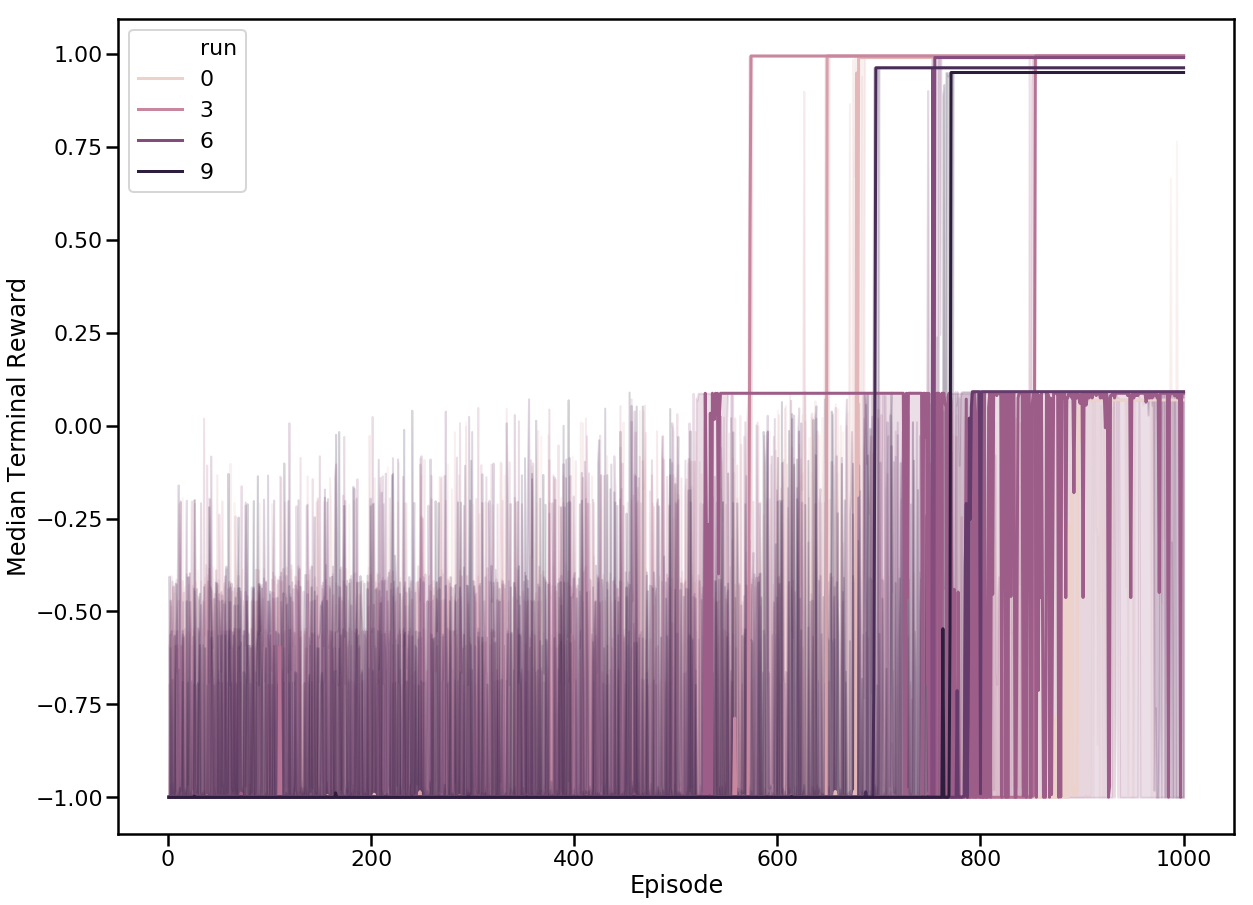

In [29]:
LCData_q_agent = ReadLCData('Q_Agent','Regular')
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = lineplot(x='Episode',y='Mean Terminal Reward',data=LCData_q_agent, hue='run' , ci=50, estimator=pd.np.median)
_ = plt.ylabel('Median Terminal Reward')

In these plots the solid line indicates the median value across evaluation episodes for a particular run while the error patch indicates the 75th and the 25th percentiles. In this plot the median performance of the agent executing the learned policy remains poor till it encounters an episode where it successfully completes the task. After that the performance of the agent remains high. We see that the variability within a particular run after the agent learns how to perform the task is quite low. However between different training runs the variability is quite high.

Also note the discrete nature of the median value. As the terminal reward is always expressed as a sum of discrete values, the median value is restricted to quantized values. The average value of the terminal reward changes between training episodes indicating that the proportion of evaluation episodes

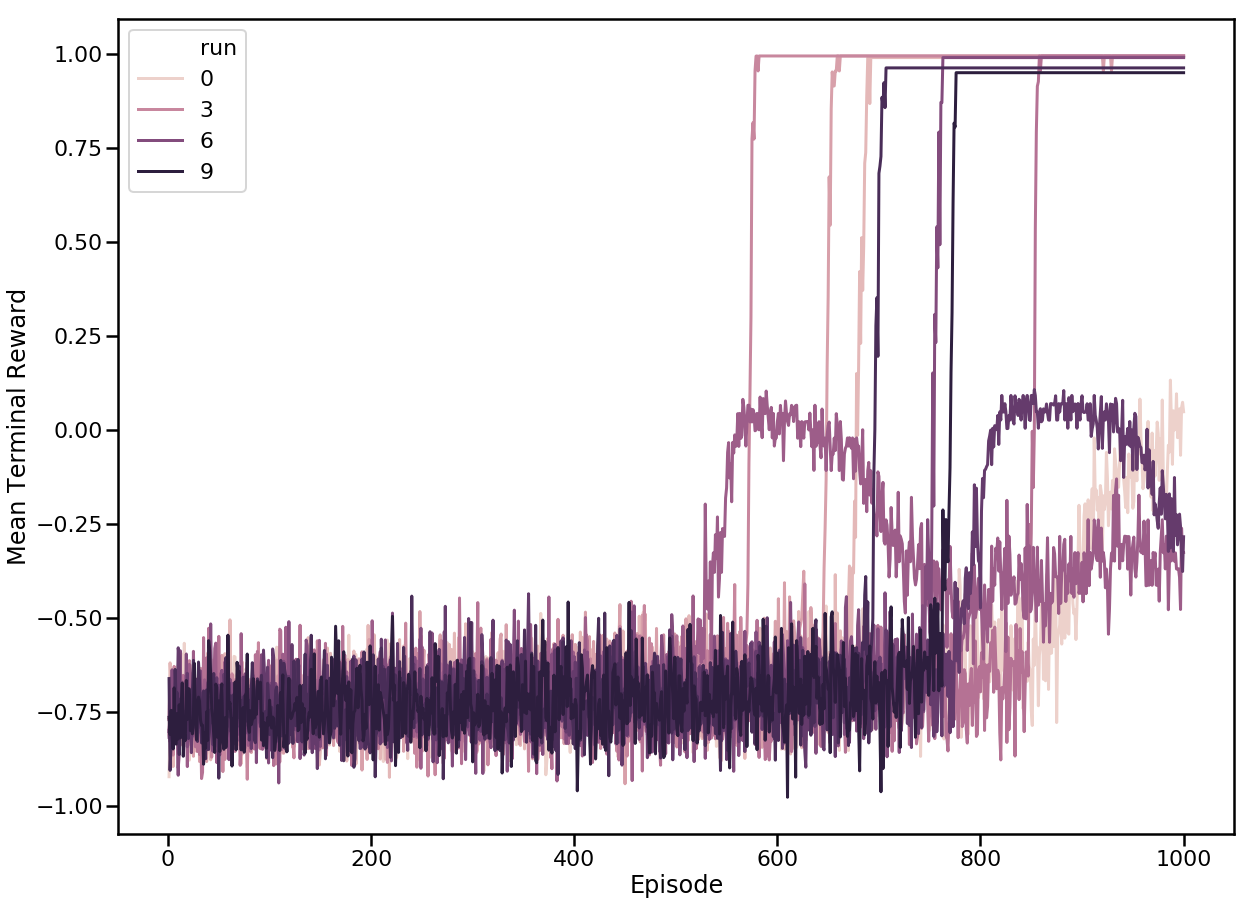

In [30]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = sns.lineplot(x='Episode',y='Mean Terminal Reward',data=LCData_q_agent, hue='run' , ci=None)

Here we observe that during three of the training runs, the learning agents did not converge to a good policy even after 1000 training episodes.

### With counterfactual updates ###

First we plot the median and the upper and lower quartiles for the agent trained with counterfactual updates.

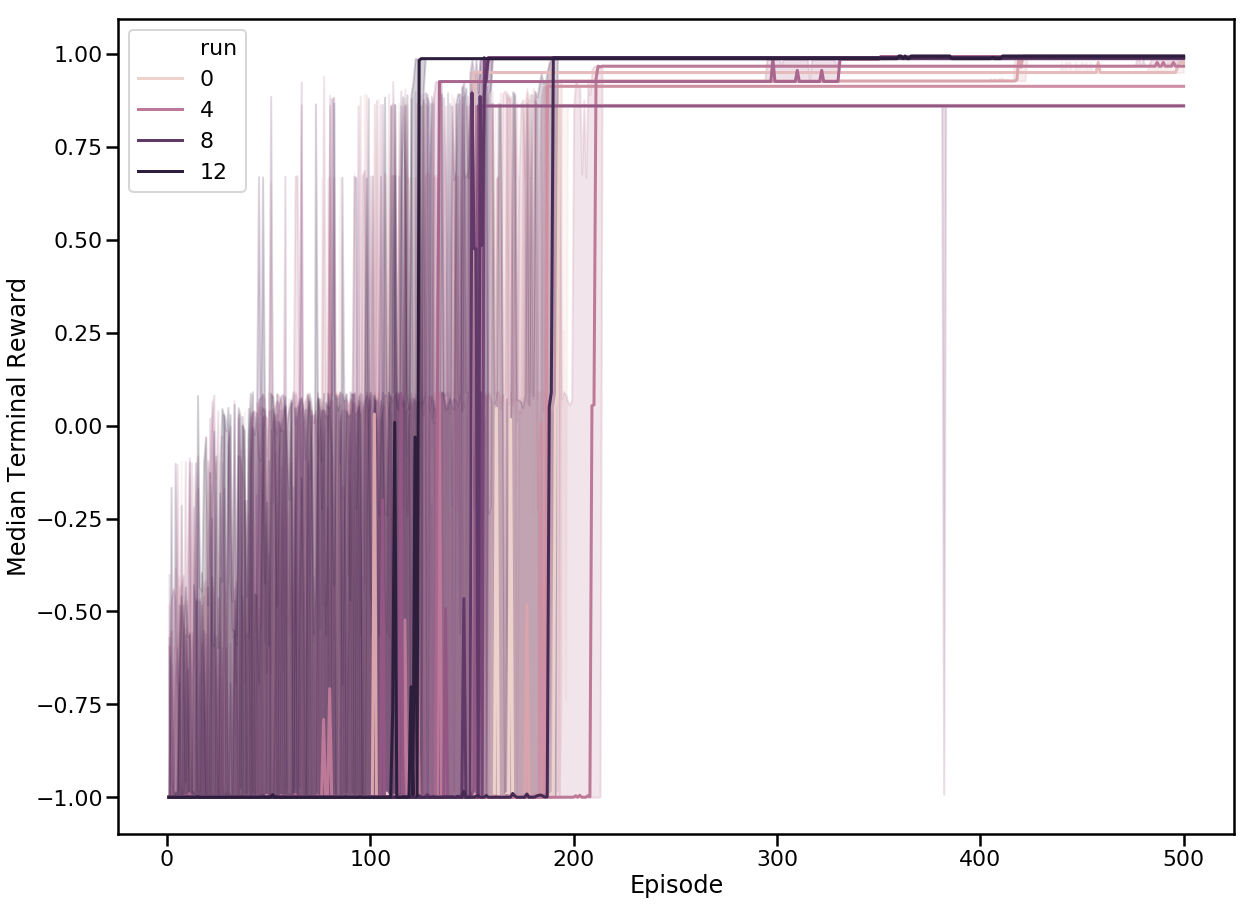

In [31]:
LCData_cfagent = ReadLCData('CFAgent','Counterfactual')
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = lineplot(x='Episode',y='Mean Terminal Reward',data=LCData_cfagent, hue='run' , ci=50, estimator=pd.np.median)
_ = plt.ylabel('Median Terminal Reward')

In contrast to the Q-learning agent without counterfactual updates, note that the jump in performance happens with fewer episodes and with a more consistent episode count with this learning agent. Also note the lower variability in the terminal rewards compared to the agent trained without counterfactual updates.

We can also record the mean values of the terminal rewards

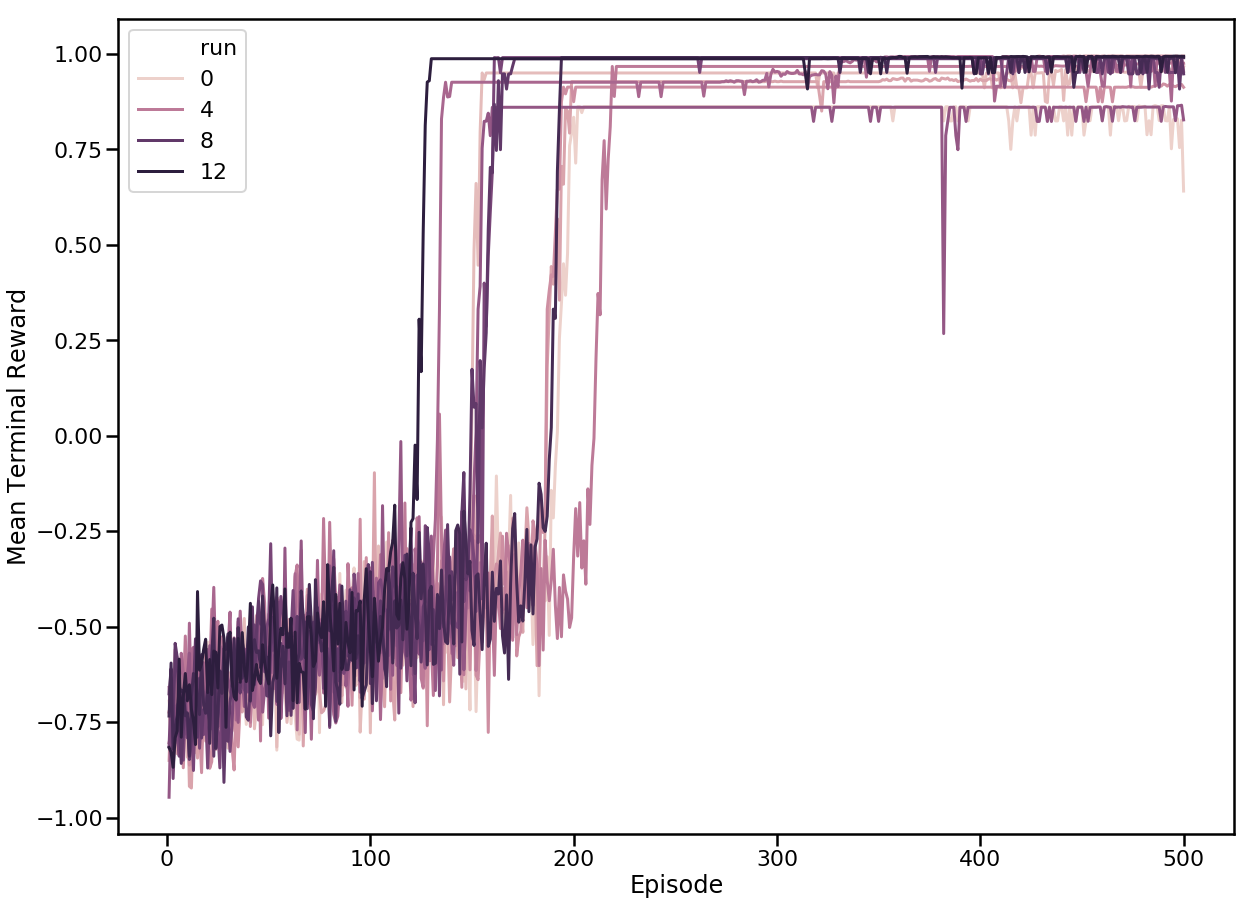

In [32]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = sns.lineplot(x='Episode',y='Mean Terminal Reward',data=LCData_cfagent, hue='run' , ci=None)

Notice the more continuous improvement in performance in the early stages of training before the jump occurs.

### Comparisons ###

Now lets plot the median performances with the upper and lower quartiles on the same chart and collapse the data along the different training runs

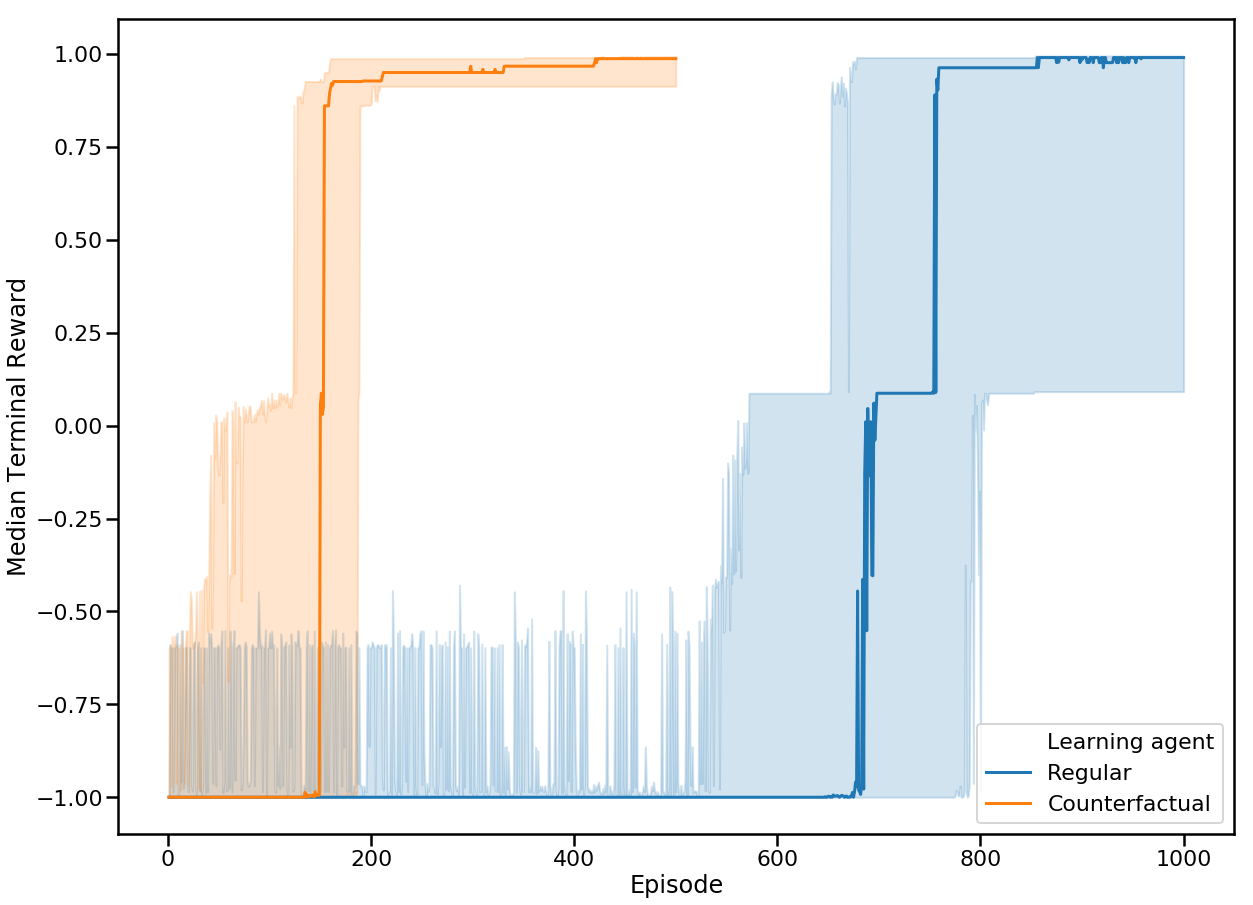

In [33]:
LCData = pd.concat([LCData_q_agent, LCData_cfagent], axis = 0, ignore_index=True)
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = lineplot(x='Episode',y='Mean Terminal Reward',data=LCData, hue='Learning agent' , ci=50, estimator=pd.np.median)
_ = plt.ylabel('Median Terminal Reward')

And now looking at the mean terminal rewards when the training runs are accumulated

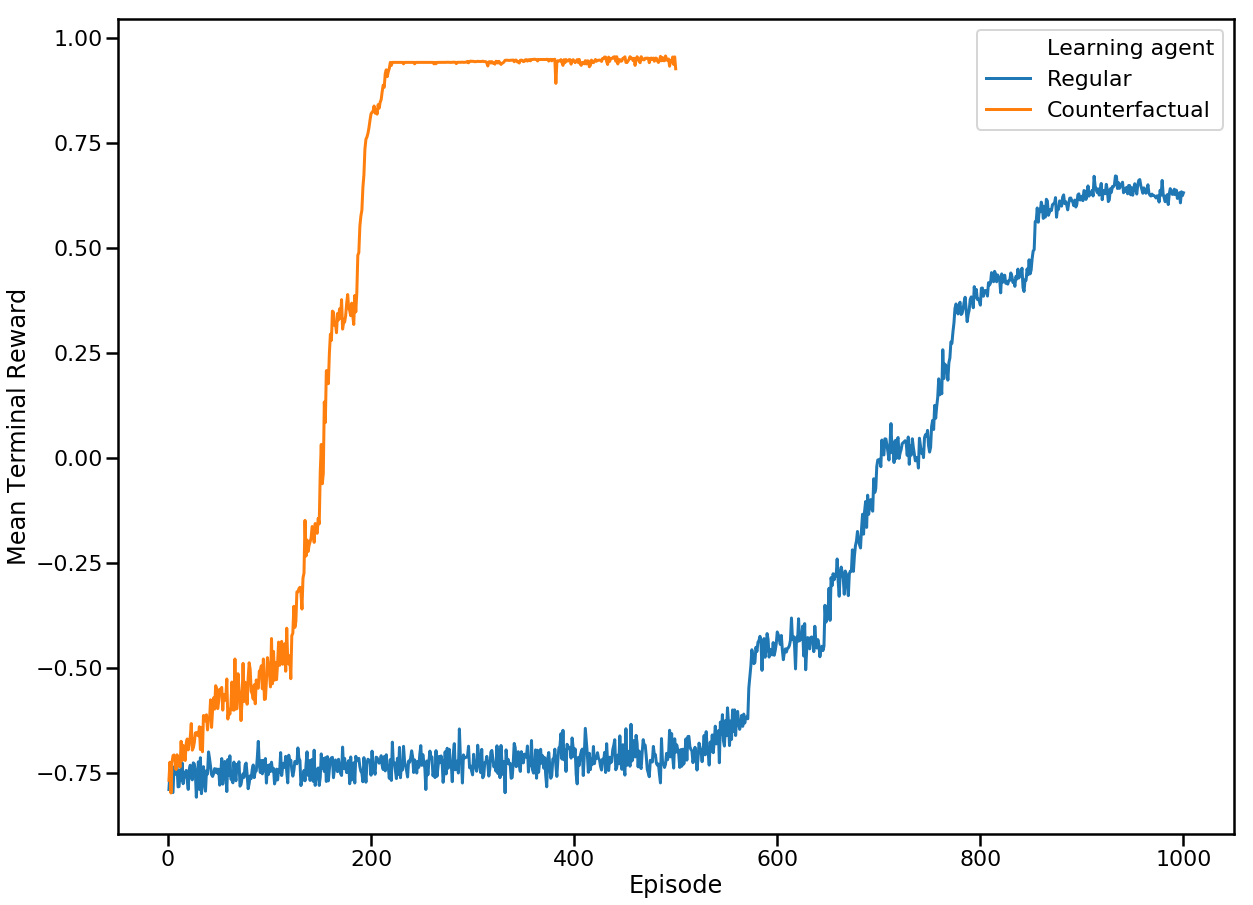

In [34]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
_ = sns.lineplot(x='Episode',y='Mean Terminal Reward',data=LCData, hue='Learning agent' , ci=None)